In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn import metrics
from torch.utils.data import DataLoader, Dataset
import math
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
import sys
import sklearn
import matplotlib
print(f'Python: {sys.version}')
print(f'NumPy: {np.__version__}')
print(f'Pandas: {pd.__version__}')
print(f'PyTorch: {torch.__version__}')
print(f'Scikit-Learn: {sklearn.__version__}')
print(f'Matplotlib: {matplotlib.__version__}')

Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
NumPy: 1.25.2
Pandas: 2.0.3
PyTorch: 2.3.0+cu121
Scikit-Learn: 1.2.2
Matplotlib: 3.7.1


In [ ]:
ATTRIBUTES = ['SOURCE', 'TARGET', 'RATING', 'TIME']
FEATURE_ATTRIBUTES = ATTRIBUTES[:2]
TARGET_ATTRIBUTE = ATTRIBUTES[2]

In [ ]:
class BitcoinOTCDataset(Dataset):
    def __init__(self, data):
        self.sources = data['SOURCE'].values.astype(np.int64)
        self.targets = data['TARGET'].values.astype(np.int64)
        self.ratings = data['RATING'].values.astype(np.float32)

    def __len__(self):
        return len(self.sources)

    def __getitem__(self, idx):
        return self.sources[idx], self.targets[idx], self.ratings[idx]

In [ ]:
def read_file(data_file):
    return pd.read_csv(data_file, names=ATTRIBUTES, skiprows=1)

def normalize_ratings(ratings):
    min_rating = ratings.min()
    max_rating = ratings.max()
    return 2 * (ratings - min_rating) / (max_rating - min_rating) - 1

class ModelR(nn.Module):
    def __init__(self, num_nodes, layer_size, num_hidden_layers):
        super(ModelR, self).__init__()
        self.source_embedding = nn.Embedding(num_nodes, layer_size)
        self.target_embedding = nn.Embedding(num_nodes, layer_size)

        layers = []
        input_size = 2 * layer_size
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(input_size, layer_size))
            layers.append(nn.ReLU())
            input_size = layer_size
        layers.append(nn.Linear(input_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, source, target):
        source_vec = self.source_embedding(source)
        target_vec = self.target_embedding(target)
        combined = torch.cat([source_vec, target_vec], dim=1)
        return self.network(combined)

def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for source, target, rating in dataloader:
        source, target, rating = source.to(device), target.to(device), rating.to(device)
        optimizer.zero_grad()
        output = model(source, target).squeeze()
        loss = criterion(output, rating)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, device):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for source, target, rating in dataloader:
            source, target, rating = source.to(device), target.to(device), rating.to(device)
            output = model(source, target).squeeze()
            predictions.append(output.cpu().numpy())
            targets.append(rating.cpu().numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    mse = metrics.mean_squared_error(targets, predictions)
    return mse, predictions, targets


In [ ]:
data_file = '/content/drive/My Drive/datamining/soc-sign-bitcoinotc.csv'
data_set = read_file(data_file)
data_set[TARGET_ATTRIBUTE] = normalize_ratings(data_set[TARGET_ATTRIBUTE])

num_nodes = max(data_set['SOURCE'].max(), data_set['TARGET'].max()) + 1

train, test = train_test_split(data_set, test_size=0.2)
train, validate = train_test_split(train, test_size=0.125)  # 0.125 * 80% = 10%
train_dataset = BitcoinOTCDataset(train)
print(f'{int(math.log2(len(train_dataset)))}')

14


Epoch 1/20, Train Loss: 0.1196958889123124, Validation Loss: 0.11219394952058792
Epoch 2/20, Train Loss: 0.09955945287607562, Validation Loss: 0.10512521117925644
Epoch 3/20, Train Loss: 0.08694968393624823, Validation Loss: 0.10291048884391785
Epoch 4/20, Train Loss: 0.07542833432241969, Validation Loss: 0.11096976697444916
Epoch 5/20, Train Loss: 0.06544622099708493, Validation Loss: 0.10848509520292282
Epoch 6/20, Train Loss: 0.05573350417909519, Validation Loss: 0.10734964907169342
Epoch 7/20, Train Loss: 0.04735479730663197, Validation Loss: 0.1111527606844902
Epoch 8/20, Train Loss: 0.041179576317812, Validation Loss: 0.12153502553701401
Epoch 9/20, Train Loss: 0.035032223782170954, Validation Loss: 0.12547126412391663
Epoch 10/20, Train Loss: 0.031332289212143025, Validation Loss: 0.12439197301864624
Epoch 11/20, Train Loss: 0.027986742745587587, Validation Loss: 0.12298540771007538
Epoch 12/20, Train Loss: 0.024925093877276306, Validation Loss: 0.12870599329471588
Epoch 13/20, 

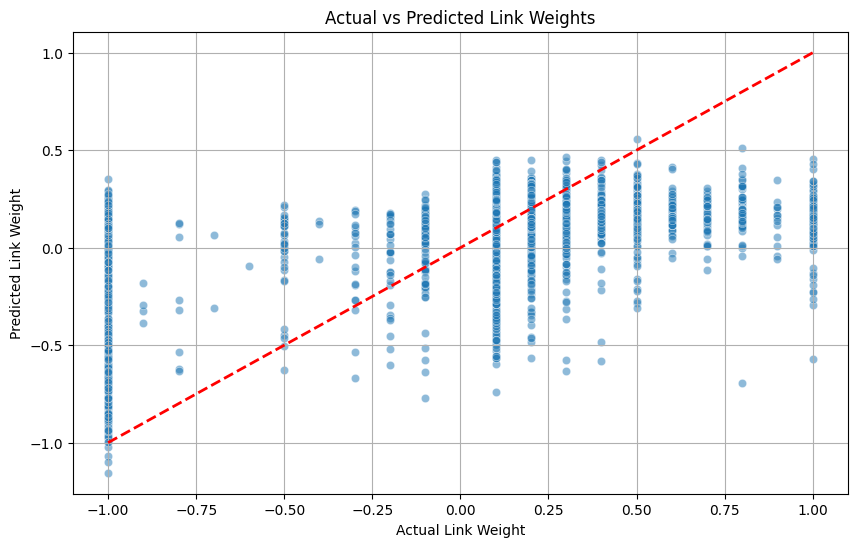

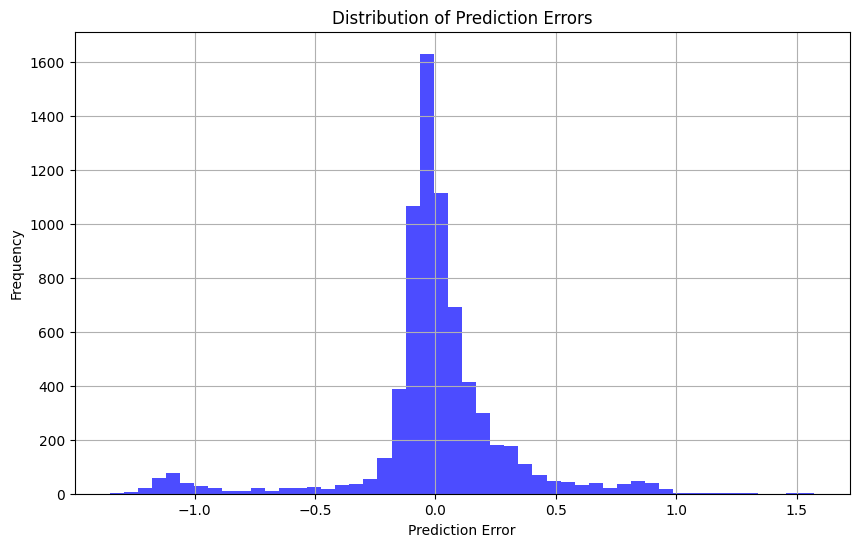

In [ ]:
def main():
    data_file = '/content/drive/My Drive/datamining/soc-sign-bitcoinotc.csv'
    data_set = read_file(data_file)
    data_set[TARGET_ATTRIBUTE] = normalize_ratings(data_set[TARGET_ATTRIBUTE])

    num_nodes = max(data_set['SOURCE'].max(), data_set['TARGET'].max()) + 1

    train, test = train_test_split(data_set, test_size=0.2)
    train, validate = train_test_split(train, test_size=0.125)  # 0.125 * 80% = 10%

    train_dataset = BitcoinOTCDataset(train)
    validate_dataset = BitcoinOTCDataset(validate)
    test_dataset = BitcoinOTCDataset(test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    layer_size = 50#int(math.log2(len(train_dataset)))
    num_hidden_layers = 3
    num_epochs = 20

    model = ModelR(num_nodes, layer_size, num_hidden_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        val_loss, _, _ = evaluate_model(model, validate_loader, device)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    model.load_state_dict(torch.load('best_model.pth'))
    test_mse, predictions, targets = evaluate_model(model, test_loader, device)
    print(f'Mean Squared Error on Test Set: {test_mse}')

    targets = np.array(targets)
    predictions = np.array(predictions)

# 检查targets和predictions是否包含0值
    print(predictions)

# 打印包含0值的元素
    #print("Targets中的0值:", targets[targets == 0])
    #print("Predictions中的0值:", predictions[predictions == 0])
    plt.figure(figsize=(10, 6))
    plt.scatter(targets, predictions, alpha=0.5, edgecolors='w', linewidth=0.5)
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--', linewidth=2)
    plt.xlabel('Actual Link Weight')
    plt.ylabel('Predicted Link Weight')
    plt.title('Actual vs Predicted Link Weights')
    plt.grid(True)
    plt.show()

    # 绘制误差分布直方图
    errors = targets - predictions
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)
    plt.show()
if __name__ == '__main__':
    main()

Epoch 1/20, Train Loss: 0.12721633061824011, Validation Loss: 0.10833844542503357
Epoch 2/20, Train Loss: 0.10270156583178487, Validation Loss: 0.10521626472473145
Epoch 3/20, Train Loss: 0.09464320260433622, Validation Loss: 0.09721048176288605
Epoch 4/20, Train Loss: 0.09080068816685516, Validation Loss: 0.09606103599071503
Epoch 5/20, Train Loss: 0.08679336148752939, Validation Loss: 0.0936577320098877
Epoch 6/20, Train Loss: 0.08335743821076619, Validation Loss: 0.09420161694288254
Epoch 7/20, Train Loss: 0.0805234495844496, Validation Loss: 0.09482832998037338
Epoch 8/20, Train Loss: 0.07875800491053615, Validation Loss: 0.09355331212282181
Epoch 9/20, Train Loss: 0.07613437631034767, Validation Loss: 0.09297358989715576
Epoch 10/20, Train Loss: 0.07434189281353443, Validation Loss: 0.09208033978939056
Epoch 11/20, Train Loss: 0.07250369850914347, Validation Loss: 0.09368294477462769
Epoch 12/20, Train Loss: 0.07075564938314038, Validation Loss: 0.09119869768619537
Epoch 13/20, Tr

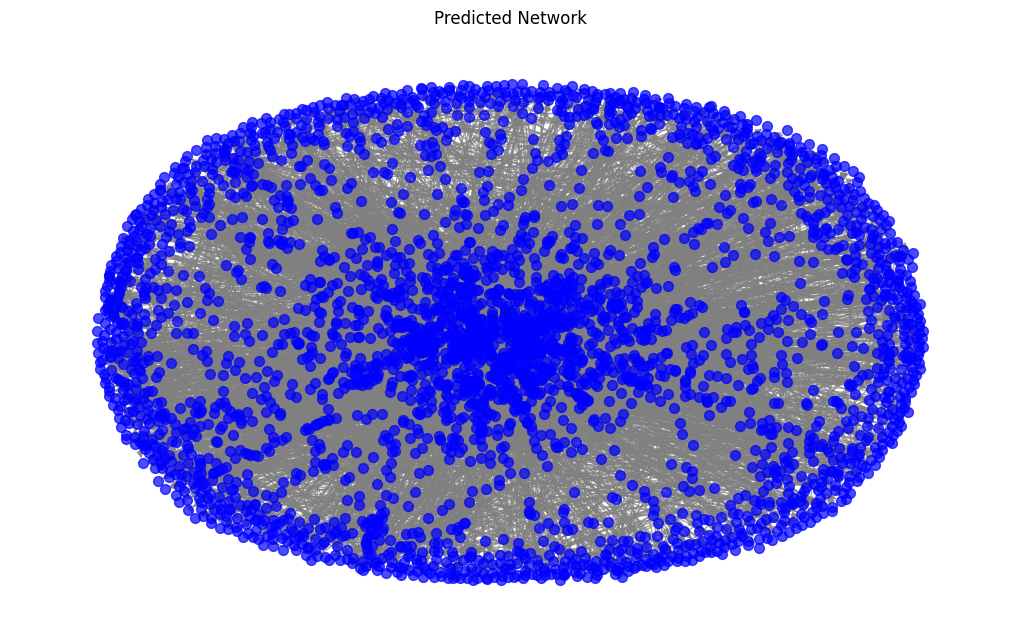

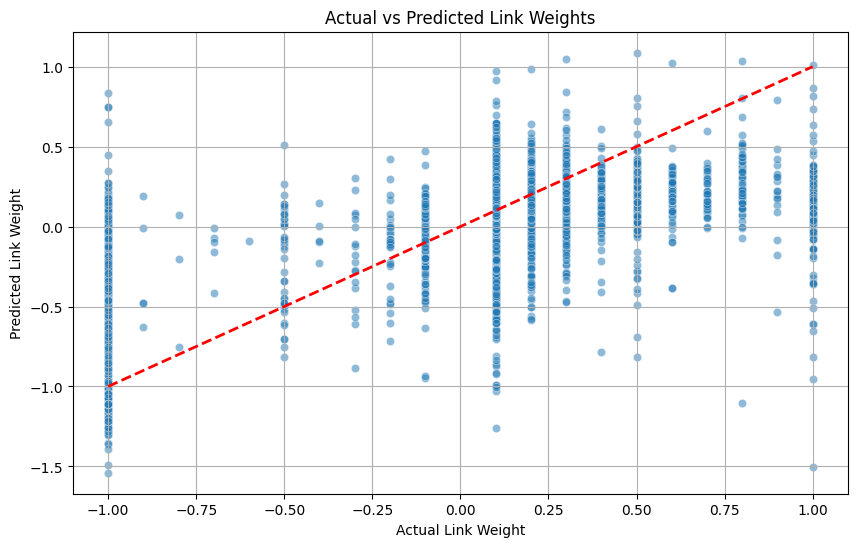

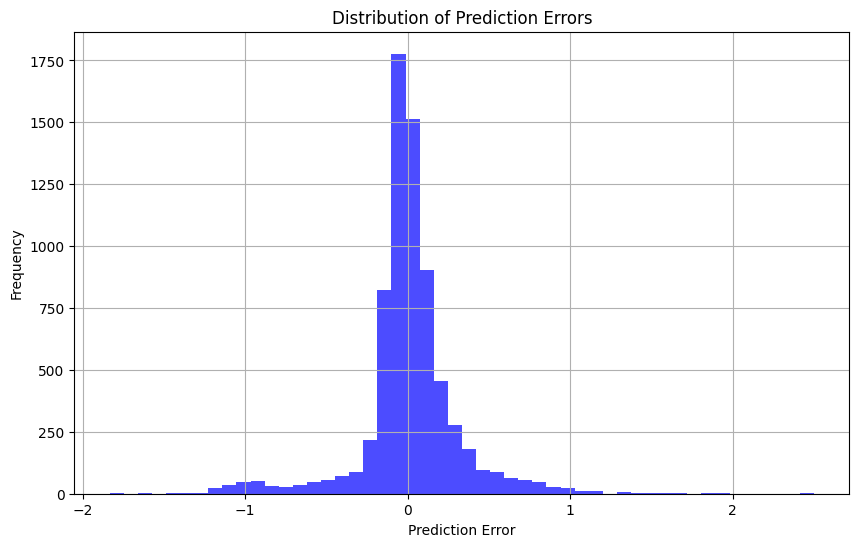

In [ ]:
class TransformerLinkPredictor(nn.Module):
    def __init__(self, num_nodes, embed_size, num_heads, num_layers, forward_expansion, dropout):
        super(TransformerLinkPredictor, self).__init__()
        self.embedding = nn.Embedding(num_nodes, embed_size)
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=embed_size,
            nhead=num_heads,
            dim_feedforward=forward_expansion * embed_size,
            dropout=dropout,
            batch_first=True  # 设置 batch_first 为 True
        )
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers)
        self.fc = nn.Linear(2 * embed_size, 1)

    def forward(self, source, target):
        source_vec = self.embedding(source).unsqueeze(1)  # (batch_size, 1, embed_size)
        target_vec = self.embedding(target).unsqueeze(1)  # (batch_size, 1, embed_size)

        source_transformed = self.transformer(source_vec).squeeze(1)  # (batch_size, embed_size)
        target_transformed = self.transformer(target_vec).squeeze(1)  # (batch_size, embed_size)

        combined = torch.cat([source_transformed, target_transformed], dim=1)  # (batch_size, 2 * embed_size)
        output = self.fc(combined)
        return output

# 定义训练函数
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for source, target, rating in dataloader:
        source, target, rating = source.to(device), target.to(device), rating.to(device)
        optimizer.zero_grad()
        output = model(source, target).squeeze()
        loss = criterion(output, rating)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# 定义评估函数
def evaluate_model(model, dataloader, device):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for source, target, rating in dataloader:
            source, target, rating = source.to(device), target.to(device), rating.to(device)
            output = model(source, target).squeeze()
            predictions.append(output.cpu().numpy())
            targets.append(rating.cpu().numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    mse = metrics.mean_squared_error(targets, predictions)
    return mse, predictions, targets

# 主函数
def main():
    data_file = '/content/drive/My Drive/datamining/soc-sign-bitcoinotc.csv'
    data_set = read_file(data_file)
    data_set['RATING'] = normalize_ratings(data_set['RATING'])

    num_nodes = max(data_set['SOURCE'].max(), data_set['TARGET'].max()) + 1

    # 划分训练集、验证集和测试集
    train, test = train_test_split(data_set, test_size=0.2)
    train, validate = train_test_split(train, test_size=0.125)  # 0.125 * 80% = 10%

    train_dataset = BitcoinOTCDataset(train)
    validate_dataset = BitcoinOTCDataset(validate)
    test_dataset = BitcoinOTCDataset(test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    embed_size = 64
    num_heads = 4
    num_layers = 2
    forward_expansion = 4
    dropout = 0.1
    num_epochs = 20

    model = TransformerLinkPredictor(num_nodes, embed_size, num_heads, num_layers, forward_expansion, dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        val_loss, _, _ = evaluate_model(model, validate_loader, device)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    model.load_state_dict(torch.load('best_model.pth'))
    test_mse, predictions, targets = evaluate_model(model, test_loader, device)
    print(f'Mean Squared Error on Test Set: {test_mse}')

    # 创建预测网络
    predicted_edges = [(source, target, weight) for source, target, weight in zip(test_dataset.sources, test_dataset.targets, predictions)]
    predicted_graph = nx.DiGraph()
    predicted_graph.add_weighted_edges_from(predicted_edges)

    # 使用networkx分析预测网络
    print("Number of nodes:", predicted_graph.number_of_nodes())
    print("Number of edges:", predicted_graph.number_of_edges())
    print("Average clustering coefficient:", nx.average_clustering(predicted_graph))

    # 绘制网络
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(predicted_graph, seed=42)  # 使用spring布局
    nx.draw(predicted_graph, pos, node_size=50, node_color='blue', edge_color='gray', alpha=0.7, with_labels=False)
    plt.title('Predicted Network')
    plt.show()

    # 绘制实际值与预测值的散点图
    plt.figure(figsize=(10, 6))
    plt.scatter(targets, predictions, alpha=0.5, edgecolors='w', linewidth=0.5)
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--', linewidth=2)
    plt.xlabel('Actual Link Weight')
    plt.ylabel('Predicted Link Weight')
    plt.title('Actual vs Predicted Link Weights')
    plt.grid(True)
    plt.show()

    # 绘制误差分布直方图
    errors = targets - predictions
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()

# 新段落

In [ ]:
def main():
    data_file = '/content/drive/My Drive/datamining/soc-sign-bitcoinotc.csv'
    data_set = read_file(data_file)
    data_set[TARGET_ATTRIBUTE] = normalize_ratings(data_set[TARGET_ATTRIBUTE])

    num_nodes = max(data_set['SOURCE'].max(), data_set['TARGET'].max()) + 1

    train, test = train_test_split(data_set, test_size=0.2)
    train, validate = train_test_split(train, test_size=0.125)  # 0.125 * 80% = 10%

    train_dataset = BitcoinOTCDataset(train)
    validate_dataset = BitcoinOTCDataset(validate)
    test_dataset = BitcoinOTCDataset(test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    layer_size = 50#int(math.log2(len(train_dataset)))
    num_hidden_layers = 4
    num_epochs = 20

    model = ModelR(num_nodes, layer_size, num_hidden_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        val_loss, _, _ = evaluate_model(model, validate_loader, device)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    model.load_state_dict(torch.load('best_model.pth'))
    test_mse, predictions, targets = evaluate_model(model, test_loader, device)
    print(f'Mean Squared Error on Test Set: {test_mse}')

# main 方法
if __name__ == '__main__':
    main()

Epoch 1/20, Train Loss: 0.11918677569251024, Validation Loss: 0.10611291974782944
Epoch 2/20, Train Loss: 0.09919104108823623, Validation Loss: 0.0977259948849678
Epoch 3/20, Train Loss: 0.08597202536462303, Validation Loss: 0.09488441795110703
Epoch 4/20, Train Loss: 0.07529132557669427, Validation Loss: 0.10162145644426346
Epoch 5/20, Train Loss: 0.06642235988220235, Validation Loss: 0.09676888585090637
Epoch 6/20, Train Loss: 0.05922112155248996, Validation Loss: 0.09788522869348526
Epoch 7/20, Train Loss: 0.05330628270477018, Validation Loss: 0.09586628526449203
Epoch 8/20, Train Loss: 0.04823666140951206, Validation Loss: 0.10508759319782257
Epoch 9/20, Train Loss: 0.0438891371726435, Validation Loss: 0.1018817201256752
Epoch 10/20, Train Loss: 0.0391946344831253, Validation Loss: 0.10861530900001526
Epoch 11/20, Train Loss: 0.03694870035565758, Validation Loss: 0.10736314952373505
Epoch 12/20, Train Loss: 0.03251228999975347, Validation Loss: 0.10952510684728622
Epoch 13/20, Trai

#25 Trials

In [ ]:
def main():
    data_file = '/content/drive/My Drive/datamining/soc-sign-bitcoinotc.csv'
    data_set = read_file(data_file)
    data_set[TARGET_ATTRIBUTE] = normalize_ratings(data_set[TARGET_ATTRIBUTE])

    num_nodes = max(data_set['SOURCE'].max(), data_set['TARGET'].max()) + 1

    # 超参数设置
    num_trials = 25
    num_hidden_layers = 3
    num_epochs = 20

    # 存储每次试验的结果
    all_results = []

    for trial in range(num_trials):
        # 数据集划分
        train, test = train_test_split(data_set, test_size=0.2)
        train, validate = train_test_split(train, test_size=0.125)  # 0.125 * 80% = 10%

        train_dataset = BitcoinOTCDataset(train)
        validate_dataset = BitcoinOTCDataset(validate)
        test_dataset = BitcoinOTCDataset(test)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        layer_size = int(math.log2(len(train_dataset)))

        model = ModelR(num_nodes, layer_size, num_hidden_layers).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        best_val_loss = float('inf')
        for epoch in range(num_epochs):
            train_loss = train_model(model, train_loader, criterion, optimizer, device)
            val_loss, _, _ = evaluate_model(model, validate_loader, device)
            print(f'Trial {trial+1}/{num_trials}, Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'best_model.pth')

        model.load_state_dict(torch.load('best_model.pth'))
        test_mse, predictions, targets = evaluate_model(model, test_loader, device)
        all_results.append(test_mse)
        print(f'Trial {trial+1}/{num_trials}, Mean Squared Error on Test Set: {test_mse}')

    avg_mse = np.mean(all_results)
    std_mse = np.std(all_results)
    print(f'Average MSE over {num_trials} trials: {avg_mse}')
    print(f'Standard Deviation of MSE over {num_trials} trials: {std_mse}')

if __name__ == '__main__':
    main()

Trial 1/25, Epoch 1/20, Train Loss: 0.1229838135799295, Validation Loss: 0.12905998528003693
Trial 1/25, Epoch 2/20, Train Loss: 0.1167604850762941, Validation Loss: 0.12439146637916565
Trial 1/25, Epoch 3/20, Train Loss: 0.10774681300154393, Validation Loss: 0.11769159138202667
Trial 1/25, Epoch 4/20, Train Loss: 0.09792659381602978, Validation Loss: 0.11426228284835815
Trial 1/25, Epoch 5/20, Train Loss: 0.09015637421526196, Validation Loss: 0.11049351841211319
Trial 1/25, Epoch 6/20, Train Loss: 0.08412802438532625, Validation Loss: 0.10861247032880783
Trial 1/25, Epoch 7/20, Train Loss: 0.07866674677477205, Validation Loss: 0.10845208168029785
Trial 1/25, Epoch 8/20, Train Loss: 0.0741639211313591, Validation Loss: 0.10654522478580475
Trial 1/25, Epoch 9/20, Train Loss: 0.06968264599762312, Validation Loss: 0.10700910538434982
Trial 1/25, Epoch 10/20, Train Loss: 0.0658459173914748, Validation Loss: 0.1066165640950203
Trial 1/25, Epoch 11/20, Train Loss: 0.06195175708648157, Valida

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def compute_common_neighbors(G, u, v):
    return len(set(G.successors(u)).intersection(set(G.predecessors(v))))

def compute_jaccard_coefficient(G, u, v):
    union_size = len(set(G.successors(u)).union(set(G.predecessors(v))))
    intersection_size = len(set(G.successors(u)).intersection(set(G.predecessors(v))))
    return intersection_size / union_size if union_size != 0 else 0

def compute_preferential_attachment(G, u, v):
    return len(G.successors(u)) * len(G.predecessors(v))

def compute_adamic_adar_index(G, u, v):
    return sum(1 / np.log(len(G.successors(w))) for w in set(G.successors(u)).intersection(set(G.predecessors(v))) if len(G.successors(w)) > 1)

def compute_resource_allocation_index(G, u, v):
    return sum(1 / len(G.successors(w)) for w in set(G.successors(u)).intersection(set(G.predecessors(v))) if len(G.successors(w)) > 0)

def compute_clustering_coefficient(G, u):
    return nx.clustering(G.to_undirected(), u)

def extract_features(G, u, v):
    return [
        compute_common_neighbors(G, u, v),
        compute_jaccard_coefficient(G, u, v),
        compute_preferential_attachment(G, u, v),
        compute_adamic_adar_index(G, u, v),
        compute_resource_allocation_index(G, u, v),
        compute_clustering_coefficient(G, u) + compute_clustering_coefficient(G, v)
    ]

def prepare_data(G):
    edges = list(G.edges(data=True))
    np.random.shuffle(edges)
    train_size = int(len(edges) * 0.8)
    train_edges = edges[:train_size]
    test_edges = edges[train_size:]

    X_train, y_train = [], []
    for u, v, data in train_edges:
        features = extract_features(G, u, v)
        X_train.append(features)
        y_train.append(data['weight'])

    X_test, y_test = [], []
    for u, v, data in test_edges:
        features = extract_features(G, u, v)
        X_test.append(features)
        y_test.append(data['weight'])

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

def train_model(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

def main():
    # Load data from CSV
    file_path = '/content/drive/My Drive/datamining/soc-sign-bitcoinotc.csv'
    data = pd.read_csv(file_path, header=None, names=['source', 'target', 'rating', 'time'])

    # Create a directed graph
    G = nx.DiGraph()

    # Add edges to the graph
    for _, row in data.iterrows():
        G.add_edge(row['source'], row['target'], weight=row['rating'])

    # Prepare data
    X_train, y_train, X_test, y_test = prepare_data(G)

    # Debugging: Check if the data preparation is correct
    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'y_test shape: {y_test.shape}')

    if len(X_train) == 0 or len(y_train) == 0 or len(X_test) == 0 or len(y_test) == 0:
        raise ValueError("Training or test data is empty. Please check the data preparation steps.")

    # Train model
    model = train_model(X_train, y_train)

    # Evaluate model
    mse = evaluate_model(model, X_test, y_test)
    print(f'Mean Squared Error: {mse}')

if __name__ == "__main__":
    main()


TypeError: object of type 'dict_keyiterator' has no len()